In [1]:

import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline


     

In [2]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [33]:
from torchvision.datasets.folder import default_loader
def is_valid_file(filepath):
    if not filepath.endswith('.jpg') and not filepath.endswith('.jpeg') and not filepath.endswith('.png'):
        return False
    try:
        default_loader(filepath)
        return True
    except:
        return False
      
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])


train_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=train_transform,
    is_valid_file=lambda x: is_valid_file(x)
)


In [24]:
train_dataset.imgs = [x for x in train_dataset.imgs if x[0] in train_files_path]
val_dataset.imgs = [x for x in val_dataset.imgs if x[0] in val_files_path]

print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  43
Количество классов в val:  43
Количество классов одинаково:  True


In [25]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))
     

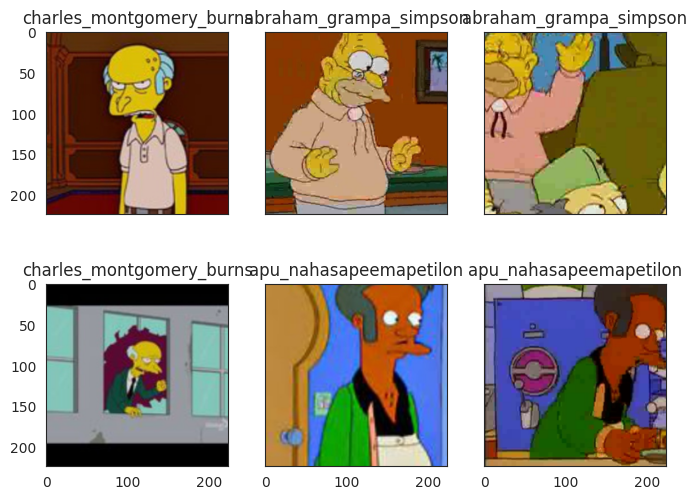

In [26]:
show_images(val_dataset)

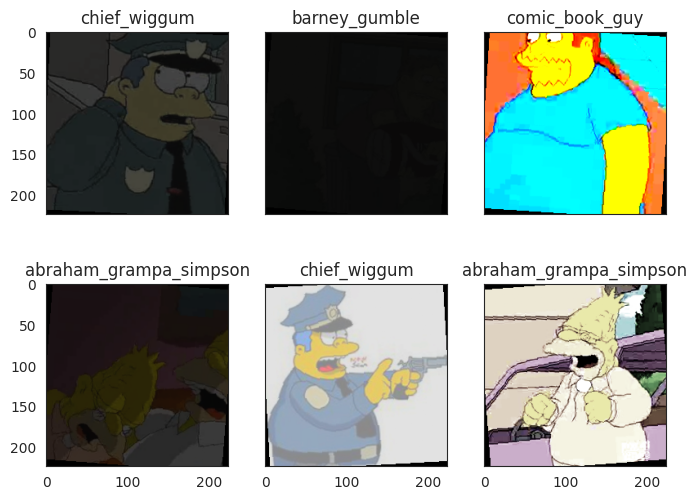

In [27]:
show_images(train_dataset)

In [9]:

def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [21]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
        
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().numpy())
            y_pred = logits.max(1)[1].detach().numpy()
            train_acc += np.mean(y_batch.cpu() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().numpy())
            y_pred = logits.max(1)[1].detach().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [22]:

batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [28]:

from torchvision.models import resnet18

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 43)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)


KeyboardInterrupt



In [32]:
val_dataset[1]

(tensor([[[0.3137, 0.3569, 0.3059,  ..., 0.4235, 0.4471, 0.4549],
          [0.4275, 0.4745, 0.4235,  ..., 0.5412, 0.5647, 0.5725],
          [0.4431, 0.4902, 0.4392,  ..., 0.5529, 0.5765, 0.5843],
          ...,
          [0.2980, 0.2980, 0.2980,  ..., 0.3569, 0.3569, 0.3569],
          [0.2980, 0.2980, 0.2980,  ..., 0.3922, 0.3922, 0.3922],
          [0.2980, 0.2980, 0.2980,  ..., 0.3804, 0.3804, 0.3804]],
 
         [[0.1333, 0.1647, 0.1216,  ..., 0.1804, 0.1686, 0.1647],
          [0.2471, 0.2824, 0.2353,  ..., 0.2980, 0.2863, 0.2824],
          [0.2627, 0.2980, 0.2549,  ..., 0.3098, 0.2980, 0.2941],
          ...,
          [0.3216, 0.3216, 0.3216,  ..., 0.3882, 0.3882, 0.3882],
          [0.3216, 0.3216, 0.3216,  ..., 0.4078, 0.4078, 0.4078],
          [0.3216, 0.3216, 0.3216,  ..., 0.3882, 0.3882, 0.3882]],
 
         [[0.1137, 0.1608, 0.1294,  ..., 0.2392, 0.2235, 0.2157],
          [0.2275, 0.2784, 0.2431,  ..., 0.3569, 0.3412, 0.3333],
          [0.2431, 0.2941, 0.2627,  ...,

In [ ]:
len(target)